In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import random
import shutil
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# download the mobilenet model and call the summary function to check out the structure of the model
#mobile = tf.keras.applications.mobilenet.MobileNet()
#mobile.summary()

## Preprocessing Images

In [ ]:
os.chdir(r"C:\Users\HR\pycharm\projects\pneumonia-test\Dataset1")

In [ ]:
train_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset1/train'
valid_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset1/valid'
test_path =  r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset2\test\blncd test'
data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

train_batches = data_generator.flow_from_directory(directory=train_path, 
                                                   target_size=(224,224), 
                                                   batch_size=10)

valid_batches = data_generator.flow_from_directory(directory=valid_path,
                                                   target_size=(224,224), 
                                                   batch_size=10)

test_batches = data_generator.flow_from_directory(directory=test_path, 
                                                  target_size=(224,224), 
                                                  batch_size=10, 
                                                  shuffle=False)



In [ ]:
#layers with parameters starting from the output layer
all_parameter_layers = [1,4,5,7,8,10,11,13,14,17,18,20,21,23,24,26,27,29,30,32,33,35,
                   36,38,39,41,42,44,45,47,48,50,51,54,55,57,58,60,61,63,64,67,68,
                   70,71,73,74,76,77,80,81,83,84,86,87]
parameter_layers = []
idx = 0
while idx < len(all_parameter_layers):
    parameter_layers.append(all_parameter_layers[idx])
    idx += 2
parameter_layers.index(74),len(parameter_layers)

In [ ]:
parameter_layers.index(45)

In [ ]:
for n in parameter_layers[24:]:
    mobile = tf.keras.applications.mobilenet.MobileNet()
    #  Build the fine-tuned model
    x = mobile.layers[-6].output
    output = Dense(units=2, activation='softmax')(x)
    model = Model(inputs=mobile.input, outputs=output)
    
    for layer in model.layers [:-n]:
        layer.trainable = False
    
    print(f"training model {n}")
    #  Compile and train the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x=train_batches,
              steps_per_epoch=len(train_batches),
              validation_data=valid_batches,
              validation_steps=len(valid_batches),
              epochs=25,
              verbose=2)

    #  Save your fine-tuned model
    model.save(f'mobilenet-full-{n}.h5')
    print(f"model {n} saved successfully")




# Evaluation

In [ ]:
test_batches.class_indices

In [ ]:
os.chdir(r'C:\Users\HR\pycharm\projects\pneumonia-test\mobilenet models')

In [ ]:
df = pd.DataFrame(columns = ["Layers_retrained",
                             "Accuracy", "Precision", "Recall","F1-score",
                             ])
for n in parameter_layers:
    print(f"model {n}")
    new_model = load_model(f'mobilenet-full-{n}.h5')
    predictions = new_model.predict(x=test_batches, steps=len(test_batches), verbose=0)
    y_pred = np.argmax(predictions, axis=-1) #returns the indices of the max value along the rows
    
    def accuracy(true_labels , predicted_labels):
        m = tf.keras.metrics.Accuracy()
        m.update_state(true_labels,predicted_labels )
        return m.result().numpy()
    
    acc = accuracy(true_labels = test_batches.classes,
                      predicted_labels = y_pred)
    print(f'accuracy: {acc}')

    def precision(true_labels , predicted_labels):
        m = tf.keras.metrics.Precision()
        m.update_state(true_labels,predicted_labels )
        return m.result().numpy()
    
    precsn = precision(true_labels = test_batches.classes,
                        predicted_labels = y_pred)
    print(f'precision: {precsn}')

    def recall(true_labels , predicted_labels):
        m = tf.keras.metrics.Recall()
        m.update_state(true_labels,predicted_labels )
        return m.result().numpy()
    
    recll = recall(true_labels = test_batches.classes,
                        predicted_labels = y_pred)
    print(f'recall: {recll}')

    from sklearn.metrics import f1_score
    def f_score(true_labels , predicted_labels):
      return f1_score(true_labels , predicted_labels)

    f1_score = f_score(true_labels = test_batches.classes,
                        predicted_labels = y_pred)
    print(f'f1-score: {f1_score}')
    print()
    df = df.append([{"Layers_retrained" : f"{n}",
            "Accuracy" : acc,
            "Precision": precsn,
           "Recall" : recll,
            "F1-score" :f1_score }],
          ignore_index = True)
df
    

In [ ]:
df.to_excel('Mobilenet_full-dataset.xlsx')

## Visuals

In [29]:
base_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\git\Pneumonia-Detection\\'
eval_results = base_path + r'MobileNet\evaluation\Mobilenet_full-dataset.xlsx'
df_full = pd.read_excel(eval_results)


In [30]:
del(df_full['Unnamed: 0'])

In [33]:
df_full.columns

Index(['Accuracy', 'Precision', 'Recall', 'F1-score'], dtype='object')

In [36]:
#df_full = df_full.set_index('Layers_retrained')
type(df_full['F1-score'])

pandas.core.series.Series

## All metrics

In [ ]:
df_full.plot()

## F1-score

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(df_full['F1-score'],color = 'red', label = 'MobileNets Unbalanced  Dataset')
plt.xlabel('Layers retrained')
plt.ylabel('F1-score')
plt.legend()
plt.title('F1 scores')
plt.show()

## F-score, precision and recall

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(df_full['F1-score'],color = 'red', label = 'F1_score')
plt.plot(df_full['Precision'],color = 'blue', label = 'Precision')
plt.plot(df_full['Recall'],color = 'green', label = 'Recall')

plt.xlabel('Layers retrained')
plt.ylabel('score')
plt.legend()
plt.title('F1 scores,Precision,Recall')
plt.show()

In [ ]:
df_full

Precision = tp/(tp + fp)  
Precision = tp/predicted positives  
High precision >> less false positives  

Recall = tp/(tp + fn)  
Recall = tp/ actual positives  
High recall >> less false negatives  

In [2]:
def prepare_image_mobilenet(file):
    #load image from file
    img = load_img(file, target_size=(224, 224))
    # convert the image pixels to a numpy array
    img_arr = img_to_array(img)
    # reshape data for the model
    img_arr = img_arr.reshape((1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2]))
    # same as np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_arr)

In [3]:
def predict(no_of_imgs, model_no):
    base_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\git\Pneumonia-Detection\\'
    normal_path = base_path + r'Datasets\Deployment\NORMAL\\'
    pneumonia_path = base_path + r'Datasets\Deployment\PNEUMONIA\\'
    paths = (normal_path, pneumonia_path)
    
    models_path = base_path + r'MobileNet\models\Unbalanced'
    os.chdir(models_path)
    new_model = load_model(f'mobilenet-full-{model_no}.h5')
    print(f"mobilenet-full-{model_no}.h5 loaded into memory")
    
    output = dict()
    output[f'model'] = f'mobilenet-full-{model_no}.h5'
    output['model no'] = model_no
    output['test imgs'] = no_of_imgs
    print(f"number of test images: {no_of_imgs}")
    for path in paths:
        preds = []
        for count,file_name in enumerate(os.listdir(path)):
            if count <= no_of_imgs and count != 0:
                file = path + file_name
                img = prepare_image_mobilenet(file)
                pred = new_model.predict(img)
                pred = np.argmax(pred, axis=-1) #returns the indices of the max value along the rows
                preds.append(pred[0])
    
        if 'NORMAL' in path:
            print(f"predictions on Normal images: {preds}")
            wrong_preds = preds.count(1)
            print(f"wrong(ie.false positives): {wrong_preds}")
            correct_preds = no_of_imgs - wrong_preds
            print(f"correct: {correct_preds}")
            output['false positives'] = wrong_preds
        else:
            print(f"predictions on pneumonia images: {preds}")
            wrong_preds = preds.count(0)
            print(f"wrong (ie.false negatives): {wrong_preds}")
            correct_preds = no_of_imgs - wrong_preds
            print(f"correct: {correct_preds}")
            output['false negatives'] = wrong_preds
    return output

In [4]:
df_results = pd.DataFrame(columns = ["Model",
                                     "Model no",
                                     "Test Images",
                                     "False Positives", 
                                     "False Negatives"
                             ])

for n in range(1, 88):
    try:
        output = predict(no_of_imgs=1500, model_no = n)
        df_results = df_results.append([{"Model" : output['model'],
                                         "Model no": output['model no'],
                                        "Test Images" : output['test imgs'],
                                        "False Positives": output['false positives'],
                                       "False Negatives" : output['false negatives']
                                 }],
                              ignore_index = True)
        print(df_results)
    except OSError:
        print(f'model {n} does not exist')
    
    
  
        
        

mobilenet-full-1.h5 loaded into memory
number of test images: 1500
predictions on Normal images: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
base_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\git\Pneumonia-Detection\\'
deployment_path = base_path + r'MobileNet\deployment'
os.chdir(deployment_path)
df_results.to_csv('deployment_results.csv')

In [11]:
#df_full

In [43]:
#test_df = test_results.set_index('Model no')
#test_df['F-score'] = df_full['F1-score']
#.chdir(base_path + r'MobileNet\evaluation')
#test_df.to_csv('false_preds_fscore.csv')

In [42]:
test_df.loc[(test_df['False Positives'] <= 4) & (test_df['False Negatives'] <= 4 )]

,Model,Test Images,False Positives,False Negatives,F-score
Model no,,,,,
14,mobilenet-full-14.h5,158,4,4,0.974684
18,mobilenet-full-18.h5,158,4,2,0.981132
48,mobilenet-full-48.h5,158,2,4,0.980892
55,mobilenet-full-55.h5,158,4,1,0.984326
58,mobilenet-full-58.h5,158,3,1,0.987421


<AxesSubplot:xlabel='Model no'>

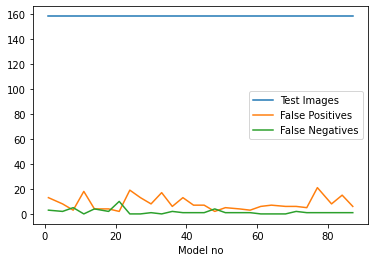

In [8]:
test_df.plot()

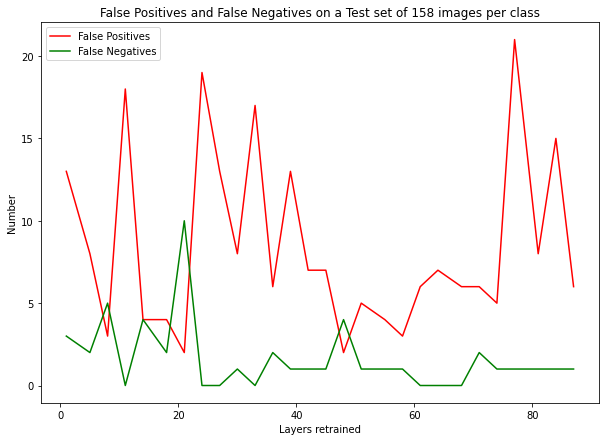

In [14]:
plt.figure(figsize = (10,7))
plt.plot(test_df['False Positives'],color = 'red', label = 'False Positives')
plt.plot(test_df['False Negatives'],color = 'green', label = 'False Negatives')

plt.xlabel('Layers retrained')
plt.ylabel('Number')
plt.legend()
plt.title('False Positives and False Negatives on a Test set of 158 images per class') 
plt.show()

## Deployment

Precision = tp/(tp + fp)
Precision = tp/predicted positives
High precision >> less false positives

Recall = tp/(tp + fn)
Recall = tp/ actual positives
High recall >> less false negatives

In [7]:
#base_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\git\Pneumonia-Detection\\'
#results_path = base_path + r'MobileNet\evaluation\test_results.xlsx'
deploy_df = pd.read_csv('deployment_results.csv')

In [8]:
deploy_df.head()

,Unnamed: 0,Model,Model no,Test Images,False Positives,False Negatives
0,0,mobilenet-full-1.h5,1,1500,110,25
1,1,mobilenet-full-5.h5,5,1500,29,16
2,2,mobilenet-full-8.h5,8,1500,7,82
3,3,mobilenet-full-11.h5,11,1500,67,8
4,4,mobilenet-full-14.h5,14,1500,17,36


In [9]:

deploy_df.columns 

Index(['Unnamed: 0', 'Model', 'Model no', 'Test Images', 'False Positives',
       'False Negatives'],
      dtype='object')

In [10]:
del(deploy_df['Unnamed: 0'])

In [12]:
deploy_df.head()

,Model,Model no,Test Images,False Positives,False Negatives
0,mobilenet-full-1.h5,1,1500,110,25
1,mobilenet-full-5.h5,5,1500,29,16
2,mobilenet-full-8.h5,8,1500,7,82
3,mobilenet-full-11.h5,11,1500,67,8
4,mobilenet-full-14.h5,14,1500,17,36


In [13]:
deploy_df['True Positives'] = deploy_df['Test Images'] - deploy_df['False Negatives']
deploy_df.head()

,Model,Model no,Test Images,False Positives,False Negatives,True Positives
0,mobilenet-full-1.h5,1,1500,110,25,1475
1,mobilenet-full-5.h5,5,1500,29,16,1484
2,mobilenet-full-8.h5,8,1500,7,82,1418
3,mobilenet-full-11.h5,11,1500,67,8,1492
4,mobilenet-full-14.h5,14,1500,17,36,1464


In [14]:
deploy_df['Precision'] = deploy_df['True Positives'] / (deploy_df['True Positives'] + deploy_df['False Positives'])
deploy_df['Recall'] = deploy_df['True Positives'] / (deploy_df['True Positives'] + deploy_df['False Negatives'])
deploy_df['F score'] = (2 * deploy_df['Precision'] * deploy_df['Recall'] ) / (deploy_df['Precision'] + deploy_df['Recall'])
deploy_df.head()

,Model,Model no,Test Images,False Positives,False Negatives,True Positives,Precision,Recall,F score
0,mobilenet-full-1.h5,1,1500,110,25,1475,0.930599,0.983333,0.956240
1,mobilenet-full-5.h5,5,1500,29,16,1484,0.980833,0.989333,0.985065
2,mobilenet-full-8.h5,8,1500,7,82,1418,0.995088,0.945333,0.969573
3,mobilenet-full-11.h5,11,1500,67,8,1492,0.957024,0.994667,0.975482
4,mobilenet-full-14.h5,14,1500,17,36,1464,0.988521,0.976000,0.982221


In [20]:
#deploy_df = deploy_df.set_index('Model no')
deploy_df.head()

,Model,Test Images,False Positives,False Negatives,True Positives,Precision,Recall,F score
Model no,,,,,,,,
1,mobilenet-full-1.h5,1500,110,25,1475,0.930599,0.983333,0.956240
5,mobilenet-full-5.h5,1500,29,16,1484,0.980833,0.989333,0.985065
8,mobilenet-full-8.h5,1500,7,82,1418,0.995088,0.945333,0.969573
11,mobilenet-full-11.h5,1500,67,8,1492,0.957024,0.994667,0.975482
14,mobilenet-full-14.h5,1500,17,36,1464,0.988521,0.976000,0.982221


In [18]:
deploy_df.to_csv('deployment_results_with_metrics.csv')

In [23]:
deploy_df = pd.read_csv('deployment_results_with_metrics.csv')
deploy_df = deploy_df.set_index('Model no')
deploy_df.head()

,Model,Test Images,False Positives,False Negatives,True Positives,Precision,Recall,F score
Model no,,,,,,,,
1,mobilenet-full-1.h5,1500,110,25,1475,0.930599,0.983333,0.956240
5,mobilenet-full-5.h5,1500,29,16,1484,0.980833,0.989333,0.985065
8,mobilenet-full-8.h5,1500,7,82,1418,0.995088,0.945333,0.969573
11,mobilenet-full-11.h5,1500,67,8,1492,0.957024,0.994667,0.975482
14,mobilenet-full-14.h5,1500,17,36,1464,0.988521,0.976000,0.982221


In [24]:
deploy_df.loc[(deploy_df['False Positives'] <= 25) & (deploy_df['False Negatives'] <= 25 )]

,Model,Test Images,False Positives,False Negatives,True Positives,Precision,Recall,F score
Model no,,,,,,,,
18,mobilenet-full-18.h5,1500,19,21,1479,0.987316,0.986000,0.986658
45,mobilenet-full-45.h5,1500,20,19,1481,0.986676,0.987333,0.987004
51,mobilenet-full-51.h5,1500,21,21,1479,0.986000,0.986000,0.986000
55,mobilenet-full-55.h5,1500,15,18,1482,0.989980,0.988000,0.988989
61,mobilenet-full-61.h5,1500,21,10,1490,0.986102,0.993333,0.989704
68,mobilenet-full-68.h5,1500,19,13,1487,0.987384,0.991333,0.989355
71,mobilenet-full-71.h5,1500,24,17,1483,0.984074,0.988667,0.986365
74,mobilenet-full-74.h5,1500,20,13,1487,0.986729,0.991333,0.989026
87,mobilenet-full-87.h5,1500,19,16,1484,0.987359,0.989333,0.988345


<AxesSubplot:xlabel='Model no'>

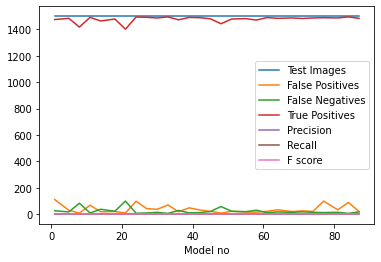

In [25]:
deploy_df.plot()

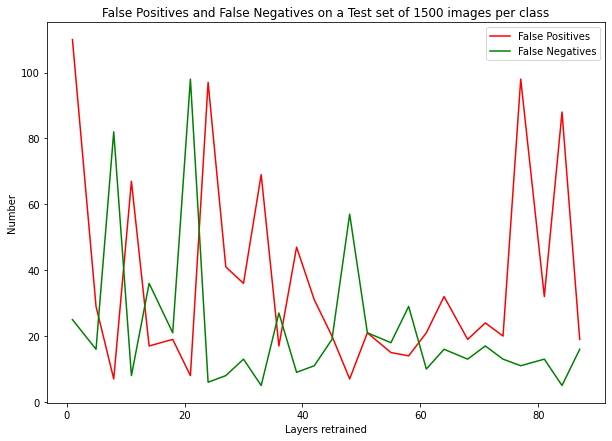

In [26]:
plt.figure(figsize = (10,7))
plt.plot(deploy_df['False Positives'],color = 'red', label = 'False Positives')
plt.plot(deploy_df['False Negatives'],color = 'green', label = 'False Negatives')

plt.xlabel('Layers retrained')
plt.ylabel('Number')
plt.legend()
plt.title('False Positives and False Negatives on a Test set of 1500 images per class') 
plt.show()

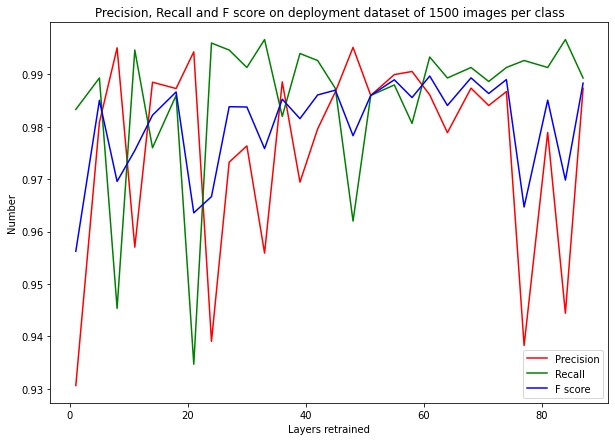

In [28]:
plt.figure(figsize = (10,7))
plt.plot(deploy_df['Precision'],color = 'red', label = 'Precision')
plt.plot(deploy_df['Recall'],color = 'green', label = 'Recall')
plt.plot(deploy_df['F score'],color = 'blue', label = 'F score')


plt.xlabel('Layers retrained')
plt.ylabel('Number')
plt.legend()
plt.title('Precision, Recall and F score on deployment dataset of 1500 images per class') 
plt.show()